In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/MyDrive

[Errno 2] No such file or directory: 'drive/MyDrive'
/content/drive/MyDrive


In [ ]:
batch_size = 8
img_height = 224
img_width = 224


In [ ]:
data_dir = pathlib.Path('Data/model_data')

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="training",
  seed=123,
  label_mode= "int",
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 4299 files belonging to 6 classes.
Using 3010 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="validation",
  seed=123,
  label_mode='int',
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 4299 files belonging to 6 classes.
Using 1289 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['diseasedapple', 'diseasedbanana', 'diseasedorange', 'freshapples', 'freshbanana', 'freshoranges']


In [ ]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 10))
# for images, labels in train_ds.take(1):
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(images[i])
#     plt.title(class_names[labels[i]])
#     plt.axis("off")


In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(8, 224, 224, 3)
(8,)


In [ ]:
from tensorflow.keras.applications import EfficientNetB0

efficient_net = EfficientNetB0(weights='imagenet', include_top= False)

efficient_net.trainable = True
print(efficient_net.summary())

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling_2 (Rescaling)         (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, None, None, 3 7           rescaling_2[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization_1[0][0]            
_____________________________________________________________________________________

In [ ]:
num_classes = 6

model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape = (img_height, img_width, 3)))

model.add(layers.Conv2D(16, 3, padding='valid', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Dropout(0.1))
model.add(layers.Conv2D(32, 3, padding='valid', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Dropout(0.1))
model.add(layers.Conv2D(64, 3, padding='valid', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Dropout(0.1))
model.add(layers.Conv2D(128, 3, padding='valid', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Dropout(0.1))

model.add(layers.Flatten())
model.add(layers.Dropout(0.4))
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(num_classes, activation = 'softmax'))


In [ ]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 111, 111, 16)      0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 109, 109, 32)      4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 54, 54, 32)       

In [ ]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

In [ ]:
checkpoint_filepath = 'checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    verbose = 1,
    save_best_only=True,
    save_weights_only=False,
    mode='max')

In [ ]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[model_checkpoint_callback]
)

Epoch 1/20
377/377 [==============================] - 1539s 4s/step - loss: 1.2522 - accuracy: 0.4844 - val_loss: 0.9247 - val_accuracy: 0.6408

Epoch 00001: val_accuracy improved from -inf to 0.64081, saving model to checkpoint
INFO:tensorflow:Assets written to: checkpoint/assets
Epoch 2/20
377/377 [==============================] - 31s 82ms/step - loss: 0.7425 - accuracy: 0.7309 - val_loss: 0.5247 - val_accuracy: 0.8394

Epoch 00002: val_accuracy improved from 0.64081 to 0.83941, saving model to checkpoint
INFO:tensorflow:Assets written to: checkpoint/assets
Epoch 3/20
377/377 [==============================] - 30s 80ms/step - loss: 0.5006 - accuracy: 0.8243 - val_loss: 0.4302 - val_accuracy: 0.8573

Epoch 00003: val_accuracy improved from 0.83941 to 0.85725, saving model to checkpoint
INFO:tensorflow:Assets written to: checkpoint/assets
Epoch 4/20
377/377 [==============================] - 30s 80ms/step - loss: 0.4347 - accuracy: 0.8475 - val_loss: 0.4213 - val_accuracy: 0.8635

Epo

In [ ]:
model.save('Data/FruitDisease_plain.h5',save_format='h5')

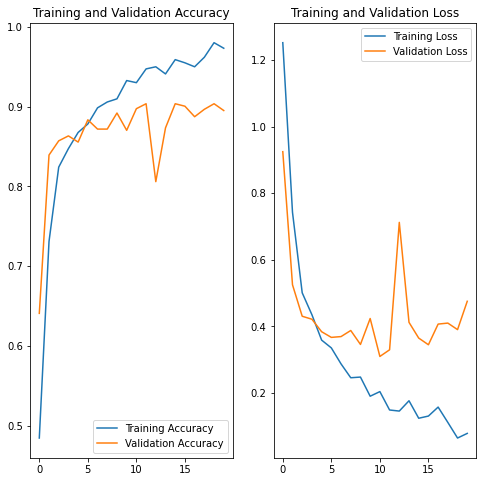

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [ ]:
model.save('FruitDisease_Dropout_SF',save_format='h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
cd ..

/content/drive/My Drive/Data


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/root/.keras/datasets/Fruit


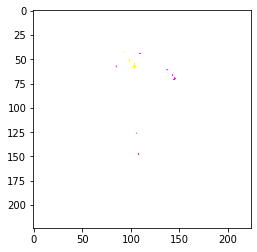

In [ ]:
url = "image.jpg"
fruit_path = tf.keras.utils.get_file('Fruit', origin=url)
print(fruit_path)
img = keras.preprocessing.image.load_img(
    fruit_path, target_size=(img_height, img_width)
)

img_array = keras.preprocessing.image.img_to_array(img)
plt.imshow(img_array)
img_array = tf.expand_dims(img_array, 0) # Create a batch




In [ ]:
predictions = model.predict(img_array)
score = predictions

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


This image most likely belongs to diseasedbanana with a 63.13 percent confidence.
